### Data Cleaning

In [1]:
# Load the DataFrame
import pandas as pd 
colleges_df = pd.read_csv('/Users/christianmoya/Documents/Flatiron/Phase_3/Phase_3_Project/colleges.csv')
colleges_df.drop(columns=['Unnamed: 0'], inplace=True, axis=1)
colleges_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   school_name                           1558 non-null   object 
 1   early_career_pay                      1558 non-null   int64  
 2   mid_career_pay                        1558 non-null   int64  
 3   meaning_percentage                    1558 non-null   int64  
 4   stem_percentage                       1558 non-null   int64  
 5   engineering                           1558 non-null   bool   
 6   private_school                        1558 non-null   bool   
 7   religious                             1558 non-null   bool   
 8   art                                   1558 non-null   bool   
 9   for_sports_fans                       1558 non-null   bool   
 10  party_school                          1558 non-null   bool   
 11  liberal_arts_scho

### Dealing with Null Values 

We find null values often where the DataFrames did not match, about 500 missing values for enrollment data, and about 300 missing values for tuition data. Room and board has about 400 missing values, but that data is also integrated into total tuition costs, so we'll get rid of that column. Since enrollment doesn't follow a normal distribution, I'm going to fill the null values with the median for each. 

In [2]:
# Drop unnecessary columns 
colleges_df.drop(columns=['school_name', 'mid_career_pay', 'room_and_board'], inplace=True)

In [3]:
# Fill in missing enrollment data 
enrollment = ['total_enrollment', 'AIAN_enrollment_percentage', 'Asian_enrollment_percentage', 'Black_enrollment_percentage','Hispanic_enrollment_percentage', 'NHPI_enrollment_percentage', 'non_resident_enrollment_percentage', 'total_minority_enrollment_percentage', 'unknown_enrollment_percentage', 'White_enrollment_percentage', 'women_enrollment_percentage']
for enroll in enrollment:
    colleges_df[enroll].fillna(colleges_df[enroll].median(), inplace=True)
    
colleges_df = colleges_df.dropna()

# Finalize model, engineer target value
colleges_df['over_60000'] = colleges_df['early_career_pay'] >= 60000
colleges_df['over_60000'] = colleges_df['over_60000'].astype(int)
colleges_df.drop(columns=['early_career_pay'], inplace=True)
colleges_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1557
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   meaning_percentage                    1201 non-null   int64  
 1   stem_percentage                       1201 non-null   int64  
 2   engineering                           1201 non-null   bool   
 3   private_school                        1201 non-null   bool   
 4   religious                             1201 non-null   bool   
 5   art                                   1201 non-null   bool   
 6   for_sports_fans                       1201 non-null   bool   
 7   party_school                          1201 non-null   bool   
 8   liberal_arts_school                   1201 non-null   bool   
 9   state_school                          1201 non-null   bool   
 10  research_university                   1201 non-null   bool   
 11  business         

### Baseline Logistic Regression Model with Scikit Learn 

In [4]:
# import necessary libraries
import statsmodels as sm 
import sklearn.preprocessing as preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from scipy import stats

X = colleges_df.drop(columns=['over_60000'], axis=1)
X = pd.get_dummies(X, drop_first=True, dtype=float)

y = colleges_df['over_60000'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
# Fit model 
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train) 

In [6]:
# Check confusion matrix 
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_train, y_hat_train)
cf

array([[783,  28],
       [ 56,  33]])

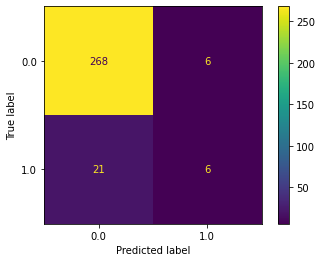

In [7]:
# Plot confusion matrix 
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(logreg, X_test, y_test)

In [8]:
# Calculate AUC 
from sklearn.metrics import roc_curve, auc
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
train_fpr, train_tpr, thresholds = roc_curve(y_test, y_score)
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))

Training AUC: 0.7960259529602595


In [9]:
# Print out scores 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Test Accuracy Score: ', accuracy_score(y_test, y_hat_test))
print('Train Accuracy Score: ', accuracy_score(y_train, y_hat_train))
print('\n')
print('Test Precision Score: ', precision_score(y_test, y_hat_test))
print('Train Precision Score: ', precision_score(y_train, y_hat_train))
print('\n')
print('Test Recall Score: ', recall_score(y_test, y_hat_test))
print('Train Recall Score: ', recall_score(y_train, y_hat_train))
print('\n')
print('Test F1 Score: ', f1_score(y_test, y_hat_test))
print('Train F1 Score: ', f1_score(y_train, y_hat_train))

Test Accuracy Score:  0.9102990033222591
Train Accuracy Score:  0.9066666666666666


Test Precision Score:  0.5
Train Precision Score:  0.5409836065573771


Test Recall Score:  0.2222222222222222
Train Recall Score:  0.3707865168539326


Test F1 Score:  0.30769230769230765
Train F1 Score:  0.44


Scores here are very low, it's actually worse than just guessing. This may be because I filled in a large chunk of null values with the median. It's probably not generating the right information. Below, we'll try addressing it. We'll have a smaller data set, but it will contain more accurate information. 

### DataFrame Removing Null Values

In [10]:
# Create new copy of DataFrame 
df = pd.read_csv('/Users/christianmoya/Documents/Flatiron/Phase_3/Phase_3_Project/colleges.csv')
df = df.dropna()
df.drop(columns=['Unnamed: 0', 'school_name', 'mid_career_pay'], inplace=True)
df['over_60000'] = df['early_career_pay'] >= 60000
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 1557
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   early_career_pay                      960 non-null    int64  
 1   meaning_percentage                    960 non-null    int64  
 2   stem_percentage                       960 non-null    int64  
 3   engineering                           960 non-null    bool   
 4   private_school                        960 non-null    bool   
 5   religious                             960 non-null    bool   
 6   art                                   960 non-null    bool   
 7   for_sports_fans                       960 non-null    bool   
 8   party_school                          960 non-null    bool   
 9   liberal_arts_school                   960 non-null    bool   
 10  state_school                          960 non-null    bool   
 11  research_universit

In [11]:
# Define features and target 
X = df.drop(columns=['early_career_pay', 'over_60000'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['over_60000']

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit model 
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)

In [12]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

from sklearn.metrics import confusion_matrix 
cf = confusion_matrix(y_train, y_hat_train)
cf

array([[636,  12],
       [ 34,  38]])

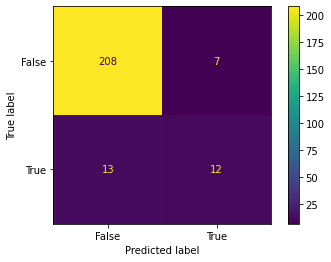

In [13]:
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(logreg, X_test, y_test)

In [14]:
from sklearn.metrics import roc_curve, auc
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
train_fpr, train_tpr, thresholds = roc_curve(y_test, y_score)
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))

Training AUC: 0.9073488372093024


Training AUC: 0.9073488372093024


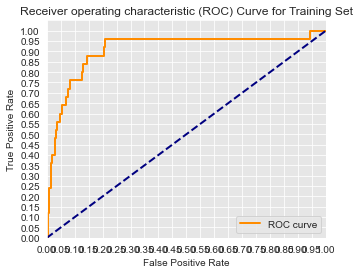

In [15]:
# Seaborn's beautiful styling
import seaborn as sns
import matplotlib.pyplot as plt 

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
ax1 = plt.figure(figsize=(5, 4))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Test Accuracy Score: ', accuracy_score(y_test, y_hat_test))
print('Train Accuracy Score: ', accuracy_score(y_train, y_hat_train))
print('\n')
print('Test Precision Score: ', precision_score(y_test, y_hat_test))
print('Train Precision Score: ', precision_score(y_train, y_hat_train))
print('\n')
print('Test Recall Score: ', recall_score(y_test, y_hat_test))
print('Train Recall Score: ', recall_score(y_train, y_hat_train))
print('\n')
print('Test F1 Score: ', f1_score(y_test, y_hat_test))
print('Train F1 Score: ', f1_score(y_train, y_hat_train))

Test Accuracy Score:  0.9166666666666666
Train Accuracy Score:  0.9361111111111111


Test Precision Score:  0.631578947368421
Train Precision Score:  0.76


Test Recall Score:  0.48
Train Recall Score:  0.5277777777777778


Test F1 Score:  0.5454545454545454
Train F1 Score:  0.6229508196721312


We find that AUC score has gone up from .79 to .90, a significat jump. Recall and F1 score are still pretty low in this case. 

### Iterations - Checking for Best Test Size

In [17]:
training_precision = []
testing_precision = []
training_recall = []
testing_recall = []
training_accuracy = []
testing_accuracy = []
training_f1 = []
testing_f1 = []

for i in range(10, 95):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i/100.0)
    logreg = LogisticRegression(fit_intercept=False, C=1e25, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    y_hat_test = logreg.predict(X_test)
    y_hat_train = logreg.predict(X_train)

    training_precision.append(precision_score(y_train, y_hat_train))
    testing_precision.append(precision_score(y_test, y_hat_test))
    training_recall.append(recall_score(y_train, y_hat_train))
    testing_recall.append(recall_score(y_test, y_hat_test))
    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    testing_accuracy.append(accuracy_score(y_test, y_hat_test))
    training_f1.append(f1_score(y_train, y_hat_train))
    testing_f1.append(f1_score(y_test, y_hat_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


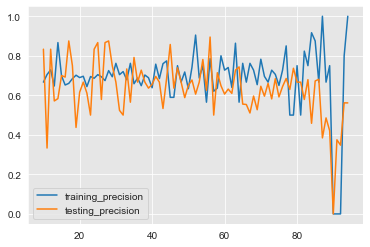

In [18]:
# Train and test precision
plt.plot(list(range(10, 95)), training_precision, label='training_precision')
plt.plot(list(range(10, 95)), testing_precision, label='testing_precision')
plt.legend()
plt.show()

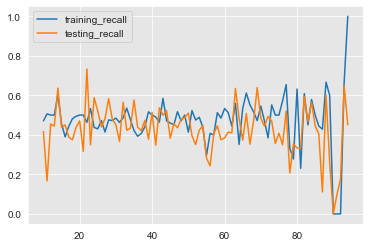

In [19]:
# Train and test recall
plt.plot(list(range(10, 95)), training_recall, label='training_recall')
plt.plot(list(range(10, 95)), testing_recall, label='testing_recall')
plt.legend()
plt.show()

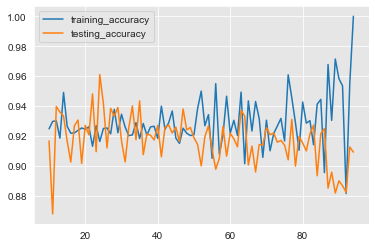

In [20]:
plt.plot(list(range(10, 95)), training_accuracy, label='training_accuracy')
plt.plot(list(range(10, 95)), testing_accuracy, label='testing_accuracy')
plt.legend()
plt.show()

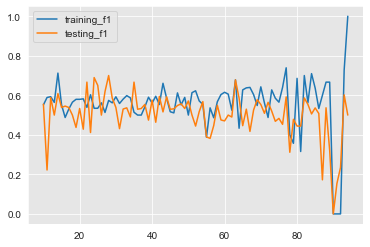

In [21]:
plt.plot(list(range(10, 95)), training_f1, label='training_f1')
plt.plot(list(range(10, 95)), testing_f1, label='testing_f1')
plt.legend()
plt.show()

Based on our plots, it looks that training and test scores are closer in proximity and higher when established at a training size of .65. This helps eliminate overfitting.

In [22]:
# Change train size to 65 and see if it improves model 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.72, random_state=42)

# Fit model 
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)

In [23]:
# Calculate AUC 
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
train_fpr, train_tpr, thresholds = roc_curve(y_test, y_score)
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))

Training AUC: 0.8826318909306461


Training AUC: 0.8826318909306461


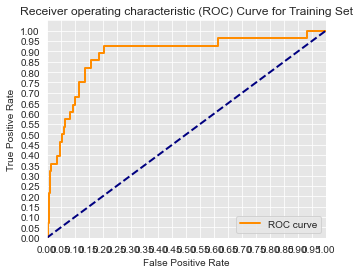

In [24]:
# ROC curve for training set
ax1 = plt.figure(figsize=(5, 4))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [25]:
# Show new confusion matrix
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

from sklearn.metrics import confusion_matrix 
cf = confusion_matrix(y_train, y_hat_train)
cf

array([[609,  13],
       [ 36,  33]])

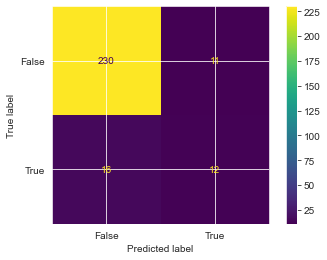

In [26]:
plot_confusion_matrix(logreg, X_test, y_test)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Test Accuracy Score: ', accuracy_score(y_test, y_hat_test))
print('Train Accuracy Score: ', accuracy_score(y_train, y_hat_train))
print('\n')
print('Test Precision Score: ', precision_score(y_test, y_hat_test))
print('Train Precision Score: ', precision_score(y_train, y_hat_train))
print('\n')
print('Test Recall Score: ', recall_score(y_test, y_hat_test))
print('Train Recall Score: ', recall_score(y_train, y_hat_train))
print('\n')
print('Test F1 Score: ', f1_score(y_test, y_hat_test))
print('Train F1 Score: ', f1_score(y_train, y_hat_train))

Test Accuracy Score:  0.8996282527881041
Train Accuracy Score:  0.9290882778581766


Test Precision Score:  0.5217391304347826
Train Precision Score:  0.717391304347826


Test Recall Score:  0.42857142857142855
Train Recall Score:  0.4782608695652174


Test F1 Score:  0.47058823529411764
Train F1 Score:  0.5739130434782609


I played with a number of test sizes, but recall seems to stick at the 72% range. We'll work with different class sizes and see if this helps at all. 

### Dealing with Class Imbalance

Based on our EDA, we know that about 10% of colleges fall under our over 60,000. We'll need to balance this out and perhaps this will help with our recall score. 

LogisticRegression(C=1e+20, fit_intercept=False)
AUC for None: 0.8850029638411381
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight='balanced', fit_intercept=False)
AUC for Balanced: 0.8970065204505039
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 2}, fit_intercept=False)
AUC for 2 to 1: 0.8626259632483699
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 10}, fit_intercept=False)
AUC for 10 to 1: 0.8974510966212211
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 100}, fit_intercept=False)
AUC for 100 to 1: 0.8974510966212211
-------------------------------------------------------------------------------------


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression(C=1e+20, class_weight={0: 1, 1: 1000}, fit_intercept=False)
AUC for 1000 to 1: 0.8891523414344991
-------------------------------------------------------------------------------------


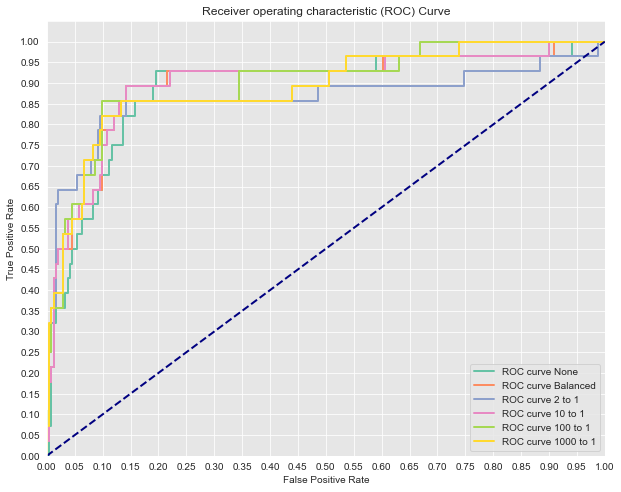

In [28]:
# Change weights 
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=1e20, class_weight=weight, solver='lbfgs')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ROC is highest when the class weight is 1000 to 1, with a score of .908.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.60, random_state=42)

In [30]:
logreg = LogisticRegression(fit_intercept=False, C=1e20, class_weight={1:1000, 0:1}, solver='lbfgs')
model_log = logreg.fit(X_train, y_train)

In [31]:
# Calculate AUC 
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
train_fpr, train_tpr, thresholds = roc_curve(y_test, y_score)
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))

Training AUC: 0.9083410367631374


In [32]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

from sklearn.metrics import confusion_matrix 
cf = confusion_matrix(y_train, y_hat_train)
cf

array([[  7, 513],
       [  0,  56]])

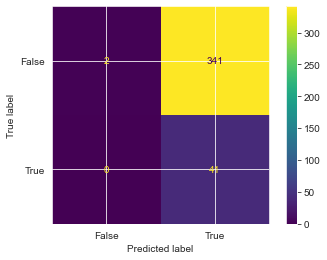

In [33]:
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(logreg, X_test, y_test)

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Test Accuracy Score: ', accuracy_score(y_test, y_hat_test))
print('Train Accuracy Score: ', accuracy_score(y_train, y_hat_train))
print('\n')
print('Test Precision Score: ', precision_score(y_test, y_hat_test))
print('Train Precision Score: ', precision_score(y_train, y_hat_train))
print('\n')
print('Test Recall Score: ', recall_score(y_test, y_hat_test))
print('Train Recall Score: ', recall_score(y_train, y_hat_train))
print('\n')
print('Test F1 Score: ', f1_score(y_test, y_hat_test))
print('Train F1 Score: ', f1_score(y_train, y_hat_train))

Test Accuracy Score:  0.11197916666666667
Train Accuracy Score:  0.109375


Test Precision Score:  0.10732984293193717
Train Precision Score:  0.0984182776801406


Test Recall Score:  1.0
Train Recall Score:  1.0


Test F1 Score:  0.1938534278959811
Train F1 Score:  0.1792


Recall score is high, but every other score is very low. Not worth using.

### SMOTE

In [35]:
# Address imbalance using SMOTE 
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [36]:
# Instantiate SMOTE and fit data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

# Fit model
model_log = logreg.fit(X_train_resampled, y_train_resampled)

In [37]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train_resampled)

from sklearn.metrics import confusion_matrix 
cf = confusion_matrix(y_train_resampled, y_hat_train)
cf

array([[  4, 516],
       [  0, 520]])

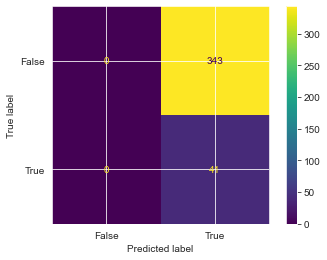

In [38]:
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(logreg, X_test, y_test)

In [39]:
from sklearn.metrics import roc_curve, auc
y_score_w_resample = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)
train_fpr, train_tpr, thresholds = roc_curve(y_test, y_score_w_resample)
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))

Training AUC: 0.9024390243902439


In [40]:
print('Test Accuracy Score: ', accuracy_score(y_test, y_hat_test))
print('Train Accuracy Score: ', accuracy_score(y_train_resampled, y_hat_train))
print('\n')
print('Test Precision Score: ', precision_score(y_test, y_hat_test))
print('Train Precision Score: ', precision_score(y_train_resampled, y_hat_train))
print('\n')
print('Test Recall Score: ', recall_score(y_test, y_hat_test))
print('Train Recall Score: ', recall_score(y_train_resampled, y_hat_train))
print('\n')
print('Test F1 Score: ', f1_score(y_test, y_hat_test))
print('Train F1 Score: ', f1_score(y_train_resampled, y_hat_train))

Test Accuracy Score:  0.10677083333333333
Train Accuracy Score:  0.5038461538461538


Test Precision Score:  0.10677083333333333
Train Precision Score:  0.5019305019305019


Test Recall Score:  1.0
Train Recall Score:  1.0


Test F1 Score:  0.19294117647058823
Train F1 Score:  0.6683804627249358


Recall score is as high as can be, but all the other scores are low. Although we are prioritizing recall, our model has such low accuracy, it's not worth using. 

### Support Vector Machines

In [76]:
# Standardize Data 
from sklearn.preprocessing import StandardScaler 
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

In [78]:
# Use Support Vector Machines to tune up model
from sklearn import svm
clf = svm.SVC(probability=True)
clf.fit(X_train_transformed, y_train)

SVC(probability=True)

In [79]:
clf.score(X_test_transformed, y_test)

0.9296875

When we use a support vector machine, we raise our score by 3%. 

### Building a Model with Statsmodel and Feature Selection

In [94]:
# Prepare DataFrame for Logistic Regression model 

# Select features removing columns with high multicollinearity 
statsmodel_df = df.drop(columns=['type', 'room_and_board', 'in_state_tuition', 'out_of_state_tuition', 'out_of_state_total', 'White_enrollment_percentage', 'unknown_enrollment_percentage', 'early_career_pay', 'art', 'NHPI_enrollment_percentage'], axis=1)

# Convert bool columns into float 
bool_col = ['engineering', 'private_school', 'religious', 'for_sports_fans', 'party_school', 'liberal_arts_school', 'state_school', 'research_university', 'business', 'sober_school', 'ivy_league']
statsmodel_df[bool_col] = statsmodel_df[bool_col].astype(float)

# Normalize Data 
def norm_feat(series):
    return (series - series.mean())/series.std()
for feat in ['total_enrollment', 'in_state_total']:
    statsmodel_df[feat] = norm_feat(statsmodel_df[feat])
    
statsmodel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 1557
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   meaning_percentage                    960 non-null    int64  
 1   stem_percentage                       960 non-null    int64  
 2   engineering                           960 non-null    float64
 3   private_school                        960 non-null    float64
 4   religious                             960 non-null    float64
 5   for_sports_fans                       960 non-null    float64
 6   party_school                          960 non-null    float64
 7   liberal_arts_school                   960 non-null    float64
 8   state_school                          960 non-null    float64
 9   research_university                   960 non-null    float64
 10  business                              960 non-null    float64
 11  sober_school      

In [142]:
features = ['meaning_percentage', 'stem_percentage', 'engineering', 'private_school', 'religious', 'for_sports_fans', 'party_school', 'in_state_total', 'state_school', 'total_minority_enrollment_percentage', 'liberal_arts_school', 'research_university', 'business', 'sober_school', 'school_rank', 'ivy_league', 'degree_length', 'research_university']
X = statsmodel_df[features]
X = pd.get_dummies(X, drop_first=True)

statsmodel_df['over_60000'] = statsmodel_df['over_60000'].astype(int)
y = statsmodel_df[['over_60000']]


In [143]:
import statsmodels.api as sm
X = sm.tools.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

         Current function value: 0.110704
         Iterations: 35


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [144]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      939
Method:                           MLE   Df Model:                           20
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.6618
Time:                        19:27:55   Log-Likelihood:                -106.28
converged:                      False   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 9.785e-76
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  -15.6242        nan        nan        nan         nan         nan
meaning_percentage                       0.1092      0.033      3.263      0.001       0.044       0.175
stem_percentage                          0.1073      0.018      6.010      0.000       0.072       0.142
engineering                              1.4950      1.210      1.236      0.217      -0.876       3.866
private_school                         -11.2094   3.27e+07  -3.42e-07      1.000   -6.41e+07    6.41e+07
religious                               -0.0161      0.487     -0.033      0.974      -0.970       0.938
for_sports_fans                          0.8510      0.494      1.722      0.085      -0.118       1.820
party_school                             0.5555      1.020      0.544      0.586      -1.444       2.555
in_state_total                           4.6010      0.706      6.518      0.000       3.217       5.985
state_school                            -4.4080        nan        nan        nan         nan         nan
total_minority_enrollment_percentage    -0.6665      1.453     -0.459      0.646      -3.515       2.182
liberal_arts_school                     -2.8835      0.694     -4.155      0.000      -4.244      -1.523
research_university                     -0.1804        nan        nan        nan         nan         nan
business                                 2.8905      0.961      3.009      0.003       1.008       4.773
sober_school                           -14.8762   2726.654     -0.005      0.996   -5359.019    5329.267
ivy_league                              18.1565   2.37e+04      0.001      0.999   -4.64e+04    4.65e+04
research_university                     -0.1804        nan        nan        nan         nan         nan
school_rank_top_100                     -0.0165      1.266     -0.013      0.990      -2.499       2.466
school_rank_top_150                     -1.1605      1.479     -0.785      0.433      -4.060       1.739
school_rank_top_200                     -1.0099      1.628     -0.620      0.535      -4.201       2.181
school_rank_top_250                    -26.2350   1.14e+06  -2.31e-05      1.000   -2.23e+06    2.23e+06
school_rank_top_50                       0.5842      1.449      0.403      0.687      -2.255       3.424
degree_length_4 Year                    12.9430        nan        nan        nan         nan         nan
========================================================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Based on our table, we find that many features don't have a p-value strong enough to prove that the feature has any impact on expected income. Let's narrow down our features and determine which have the biggest effect. 

In [161]:
features = ['meaning_percentage', 'stem_percentage', 'private_school', 'Asian_enrollment_percentage', 'Black_enrollment_percentage', 'for_sports_fans', 'in_state_total', 'liberal_arts_school', 'business', 'school_rank', 'non_resident_enrollment_percentage']

X = statsmodel_df[features]
X = pd.get_dummies(X, drop_first=True)

statsmodel_df['over_60000'] = statsmodel_df['over_60000'].astype(int)
y = statsmodel_df[['over_60000']]

In [162]:
X = sm.tools.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

         Current function value: 0.104439
         Iterations: 35


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [163]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      944
Method:                           MLE   Df Model:                           15
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.6810
Time:                        19:38:22   Log-Likelihood:                -100.26
converged:                      False   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 8.830e-82
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -7.1147      1.751     -4.062      0.000     -10.547      -3.682
meaning_percentage                     0.0887      0.031      2.889      0.004       0.029       0.149
stem_percentage                        0.1067      0.016      6.850      0.000       0.076       0.137
private_school                        -5.2530      1.413     -3.718      0.000      -8.022      -2.484
Asian_enrollment_percentage            8.2380      3.484      2.365      0.018       1.410      15.066
Black_enrollment_percentage          -10.3621      6.686     -1.550      0.121     -23.467       2.743
for_sports_fans                        1.0101      0.474      2.131      0.033       0.081       1.939
in_state_total                         3.6199      0.682      5.305      0.000       2.283       4.957
liberal_arts_school                   -2.4248      0.675     -3.592      0.000      -3.748      -1.102
business                               2.8485      1.019      2.797      0.005       0.852       4.845
non_resident_enrollment_percentage     4.8981      2.870      1.707      0.088      -0.727      10.523
school_rank_top_100                   -0.4350      0.728     -0.598      0.550      -1.861       0.991
school_rank_top_150                   -1.8866      0.991     -1.904      0.057      -3.829       0.056
school_rank_top_200                   -1.4138      1.383     -1.022      0.307      -4.125       1.297
school_rank_top_250                   -8.5805    158.148     -0.054      0.957    -318.545     301.384
school_rank_top_50                     0.3197      0.945      0.338      0.735      -1.533       2.172
======================================================================================================

Possibly complete quasi-separation: A fraction 0.17 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [164]:
# Let's look specifically at school types
features = ['engineering', 'private_school', 'religious', 'for_sports_fans', 'party_school', 'liberal_arts_school', 'state_school', 'research_university', 'business', 'sober_school', 'ivy_league']
X = statsmodel_df[features]
X = pd.get_dummies(X, drop_first=True)

statsmodel_df['over_60000'] = statsmodel_df['over_60000'].astype(int)
y = statsmodel_df[['over_60000']]

X = sm.tools.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

result.summary()

         Current function value: 0.203806
         Iterations: 35


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      949
Method:                           MLE   Df Model:                           10
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.3774
Time:                        19:42:17   Log-Likelihood:                -195.65
converged:                      False   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 2.607e-45
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.8858   7.12e+06  -4.05e-07      1.000    -1.4e+07     1.4e+07
engineering             5.4492      0.822      6.631      0.000       3.838       7.060
private_school          0.0129   7.12e+06   1.82e-09      1.000    -1.4e+07     1.4e+07
religious              -1.1912      0.318     -3.745      0.000      -1.815      -0.568
for_sports_fans         1.6876      0.352      4.798      0.000       0.998       2.377
party_school            0.3711      0.755      0.492      0.623      -1.109       1.851
liberal_arts_school     1.2042      0.364      3.312      0.001       0.492       1.917
state_school           -2.8988   7.12e+06  -4.07e-07      1.000    -1.4e+07     1.4e+07
research_university     1.6693      0.363      4.596      0.000       0.958       2.381
business                1.9392      0.668      2.903      0.004       0.630       3.249
sober_school          -26.9564   7.85e+05  -3.43e-05      1.000   -1.54e+06    1.54e+06
ivy_league             19.7638   1.02e+04      0.002      0.998   -1.99e+04       2e+04
=======================================================================================
"""

Based on p-values, school types that should remain in our model are: engineering, relgious, for_sports_fans, liberal_arts_school, research_university and business. 

In [165]:
# Let's look specifically at enrollment
features = ['AIAN_enrollment_percentage', 'Asian_enrollment_percentage', 'Black_enrollment_percentage', 'Hispanic_enrollment_percentage', 'non_resident_enrollment_percentage', 'total_minority_enrollment_percentage', 'women_enrollment_percentage']
X = statsmodel_df[features]
X = pd.get_dummies(X, drop_first=True)

statsmodel_df['over_60000'] = statsmodel_df['over_60000'].astype(int)
y = statsmodel_df[['over_60000']]

X = sm.tools.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.160062
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      952
Method:                           MLE   Df Model:                            7
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.5111
Time:                        19:46:42   Log-Likelihood:                -153.66
converged:                       True   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 1.766e-65
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    3.5588      0.828      4.296      0.000       1.935       5.182
AIAN_enrollment_percentage             -25.9608     32.245     -0.805      0.421     -89.161      37.239
Asian_enrollment_percentage             38.0020      7.612      4.993      0.000      23.083      52.921
Black_enrollment_percentage             -8.6493      6.698     -1.291      0.197     -21.776       4.478
Hispanic_enrollment_percentage           7.5547      6.083      1.242      0.214      -4.368      19.478
non_resident_enrollment_percentage       5.5259      1.875      2.947      0.003       1.850       9.201
total_minority_enrollment_percentage   -10.9554      5.259     -2.083      0.037     -21.263      -0.648
women_enrollment_percentage            -10.6314      1.411     -7.533      0.000     -13.397      -7.865
========================================================================================================

Possibly complete quasi-separation: A fraction 0.10 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Again, based on our p-values, it looks like enrollment for Asians, non-residents, and women have statistical significance. 

In [167]:
# Let's look specifically at school types
features = ['school_rank']
X = statsmodel_df[features]
X = pd.get_dummies(X, drop_first=True)

statsmodel_df['over_60000'] = statsmodel_df['over_60000'].astype(int)
y = statsmodel_df[['over_60000']]

X = sm.tools.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

result.summary()

         Current function value: 0.241849
         Iterations: 35


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      954
Method:                           MLE   Df Model:                            5
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.2612
Time:                        19:48:53   Log-Likelihood:                -232.18
converged:                      False   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 1.264e-33
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.7662      0.147    -18.782      0.000      -3.055      -2.478
school_rank_top_100     2.2962      0.429      5.350      0.000       1.455       3.137
school_rank_top_150     1.5134      0.486      3.115      0.002       0.561       2.466
school_rank_top_200    -0.5660      1.028     -0.550      0.582      -2.581       1.449
school_rank_top_250   -16.8658   4581.183     -0.004      0.997   -8995.820    8962.088
school_rank_top_50      5.1016      0.622      8.198      0.000       3.882       6.321
=======================================================================================
"""

When on its own, school rank seems to have a strong p value.

In [168]:
# Combining features together
# Let's look specifically at school types
features = ['engineering', 'religious', 'for_sports_fans', 'liberal_arts_school', 'research_university', 'Asian_enrollment_percentage', 'non_resident_enrollment_percentage', 'women_enrollment_percentage', 'school_rank']
X = statsmodel_df[features]
X = pd.get_dummies(X, drop_first=True)

statsmodel_df['over_60000'] = statsmodel_df['over_60000'].astype(int)
y = statsmodel_df[['over_60000']]

X = sm.tools.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

result.summary()

         Current function value: 0.136452
         Iterations: 35


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      946
Method:                           MLE   Df Model:                           13
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.5832
Time:                        19:52:21   Log-Likelihood:                -130.99
converged:                      False   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 2.539e-70
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.1413      0.857     -0.165      0.869      -1.821       1.539
engineering                            3.2926      0.929      3.543      0.000       1.471       5.114
religious                             -0.0775      0.373     -0.208      0.835      -0.809       0.654
for_sports_fans                        1.6771      0.437      3.835      0.000       0.820       2.534
liberal_arts_school                    1.5412      0.414      3.724      0.000       0.730       2.352
research_university                   -2.2112      1.002     -2.208      0.027      -4.174      -0.248
Asian_enrollment_percentage           23.7349      3.328      7.132      0.000      17.212      30.257
non_resident_enrollment_percentage     6.2817      2.137      2.939      0.003       2.093      10.471
women_enrollment_percentage           -9.4865      1.603     -5.917      0.000     -12.629      -6.344
school_rank_top_100                    3.1372      1.065      2.946      0.003       1.050       5.224
school_rank_top_150                    0.6187      1.162      0.532      0.594      -1.659       2.896
school_rank_top_200                    0.2354      1.521      0.155      0.877      -2.745       3.216
school_rank_top_250                  -12.1838   1432.697     -0.009      0.993   -2820.218    2795.851
school_rank_top_50                     4.9731      1.129      4.406      0.000       2.761       7.185
======================================================================================================
"""

In [210]:
# Let's get rid of features with low p-values 
features = ['engineering', 'for_sports_fans', 'liberal_arts_school', 'research_university', 'Asian_enrollment_percentage']
X = statsmodel_df[features]
X = pd.get_dummies(X, drop_first=True)

statsmodel_df['over_60000'] = statsmodel_df['over_60000'].astype(int)
y = statsmodel_df[['over_60000']]

X = sm.tools.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.202187
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      954
Method:                           MLE   Df Model:                            5
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.3824
Time:                        20:27:08   Log-Likelihood:                -194.10
converged:                       True   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 6.482e-50
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -4.7548      0.338    -14.084      0.000      -5.416      -4.093
engineering                     5.1354      0.712      7.212      0.000       3.740       6.531
for_sports_fans                 1.2795      0.347      3.689      0.000       0.600       1.959
liberal_arts_school             1.5166      0.371      4.088      0.000       0.790       2.244
research_university             0.8368      0.365      2.292      0.022       0.121       1.552
Asian_enrollment_percentage    22.1840      2.576      8.613      0.000      17.136      27.232
===============================================================================================
"""

In [227]:
# Add additional features
features = ['engineering', 'for_sports_fans', 'liberal_arts_school', 'research_university', 'Asian_enrollment_percentage', 'non_resident_enrollment_percentage', 'women_enrollment_percentage', 'school_rank', 'meaning_percentage', 'stem_percentage', 'in_state_total']
X = statsmodel_df[features]
X = pd.get_dummies(X, drop_first=True)

statsmodel_df['over_60000'] = statsmodel_df['over_60000'].astype(int)
y = statsmodel_df[['over_60000']]

X = sm.tools.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

result.summary()

         Current function value: 0.101254
         Iterations: 35


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      944
Method:                           MLE   Df Model:                           15
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.6907
Time:                        20:38:06   Log-Likelihood:                -97.204
converged:                      False   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 4.548e-83
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -5.6168      1.738     -3.232      0.001      -9.023      -2.211
engineering                            0.6640      1.417      0.469      0.639      -2.113       3.441
for_sports_fans                        1.5321      0.508      3.014      0.003       0.536       2.528
liberal_arts_school                   -1.1586      0.619     -1.873      0.061      -2.371       0.054
research_university                    0.0805      1.297      0.062      0.951      -2.461       2.622
Asian_enrollment_percentage           18.6816      3.843      4.861      0.000      11.149      26.214
non_resident_enrollment_percentage     5.1782      2.506      2.067      0.039       0.267      10.089
women_enrollment_percentage           -9.2286      1.607     -5.741      0.000     -12.379      -6.078
meaning_percentage                     0.0700      0.026      2.676      0.007       0.019       0.121
stem_percentage                        0.0781      0.018      4.329      0.000       0.043       0.113
in_state_total                         2.1065      0.369      5.701      0.000       1.382       2.831
school_rank_top_100                    0.0387      1.442      0.027      0.979      -2.788       2.866
school_rank_top_150                   -2.0133      1.627     -1.237      0.216      -5.203       1.176
school_rank_top_200                   -2.0501      2.002     -1.024      0.306      -5.975       1.875
school_rank_top_250                   -4.1958     25.299     -0.166      0.868     -53.780      45.388
school_rank_top_50                     0.4724      1.581      0.299      0.765      -2.626       3.571
======================================================================================================
"""

Although meaning and stem percentage have low p values, their coefficients are so low that it doesn't really impact the model. 

In [228]:
features = ['engineering', 'for_sports_fans', 'liberal_arts_school', 'research_university', 'Asian_enrollment_percentage', 'non_resident_enrollment_percentage', 'women_enrollment_percentage', 'school_rank_top_50', 'school_rank_top_100']
X = X[features]

statsmodel_df['over_60000'] = statsmodel_df['over_60000'].astype(int)
y = statsmodel_df[['over_60000']]

X = sm.tools.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.136751
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      950
Method:                           MLE   Df Model:                            9
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.5823
Time:                        20:39:29   Log-Likelihood:                -131.28
converged:                       True   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 2.452e-73
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.1781      0.854     -0.209      0.835      -1.852       1.496
engineering                            3.4183      0.912      3.748      0.000       1.631       5.206
for_sports_fans                        1.6713      0.433      3.858      0.000       0.822       2.520
liberal_arts_school                    1.5505      0.414      3.748      0.000       0.740       2.361
research_university                   -1.9078      0.655     -2.915      0.004      -3.191      -0.625
Asian_enrollment_percentage           23.7254      3.279      7.235      0.000      17.298      30.153
non_resident_enrollment_percentage     6.3865      2.103      3.037      0.002       2.264      10.509
women_enrollment_percentage           -9.4998      1.587     -5.986      0.000     -12.610      -6.389
school_rank_top_50                     4.6797      0.849      5.514      0.000       3.016       6.343
school_rank_top_100                    2.8388      0.752      3.774      0.000       1.365       4.313
======================================================================================================
"""

### Back to Scikit Learn to Measure Accuracy

In [229]:
# Define features and target 

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit model 
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [171]:
# Check confusion matrix 
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_train, y_hat_train)
cf

array([[640,   8],
       [ 26,  46]])

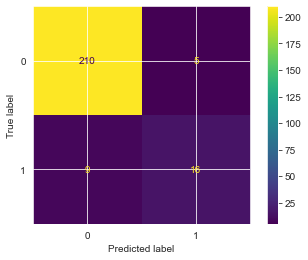

In [230]:
# Plot confusion matrix 
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(logreg, X_test, y_test)

Training AUC: 0.9024390243902439


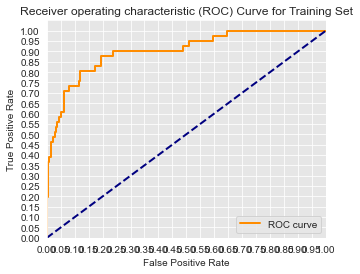

In [231]:
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
ax1 = plt.figure(figsize=(5, 4))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [232]:
# Print out scores 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Test Accuracy Score: ', accuracy_score(y_test, y_hat_test))
print('Train Accuracy Score: ', accuracy_score(y_train, y_hat_train))
print('\n')
print('Test Precision Score: ', precision_score(y_test, y_hat_test))
print('Train Precision Score: ', precision_score(y_train, y_hat_train))
print('\n')
print('Test Recall Score: ', recall_score(y_test, y_hat_test))
print('Train Recall Score: ', recall_score(y_train, y_hat_train))
print('\n')
print('Test F1 Score: ', f1_score(y_test, y_hat_test))
print('Train F1 Score: ', f1_score(y_train, y_hat_train))

Test Accuracy Score:  0.9416666666666667
Train Accuracy Score:  0.9527777777777777


Test Precision Score:  0.7619047619047619
Train Precision Score:  0.8518518518518519


Test Recall Score:  0.64
Train Recall Score:  0.6388888888888888


Test F1 Score:  0.6956521739130435
Train F1 Score:  0.7301587301587301


In [251]:
# Use Support Vector Machine to improve model performance 
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9291666666666667

After fine tuning our features, our scores went up across the board. In conclusion, what most impacts expected income are type of school: engineering, for sports fans, liberal arts schools, research universities, Asian enrollment, non-resident enrollment, women enrollment, and rank (top 50 and top 100). 

In [233]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:             over_60000   No. Observations:                  960
Model:                          Logit   Df Residuals:                      950
Method:                           MLE   Df Model:                            9
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                  0.5823
Time:                        20:40:01   Log-Likelihood:                -131.28
converged:                       True   LL-Null:                       -314.27
Covariance Type:            nonrobust   LLR p-value:                 2.452e-73
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.1781      0.854     -0.209      0.835      -1.852       1.496
engineering                            3.4183      0.912   

In [206]:
coef = [3.4183, 1.6713, 1.5505, -1.9078, 23.7254, 6.3865, -9.4998, 4.6797, 2.8388]
features = ['engineering', 'for_sports_fans', 'liberal_arts_school', 'research_university', 'Asian_enrollment_percentage', 'non_resident_enrollment_percentage', 'women_enrollment_percentage', 'school_rank_top_50', 'school_rank_top_100']

features_df = pd.DataFrame({'coef': coef, 'features':features})
features_df.sort_values(by='coef', inplace=True)

Text(0.5, 1.0, 'Impact School Features Have on Expected Income of $60,000 or More')

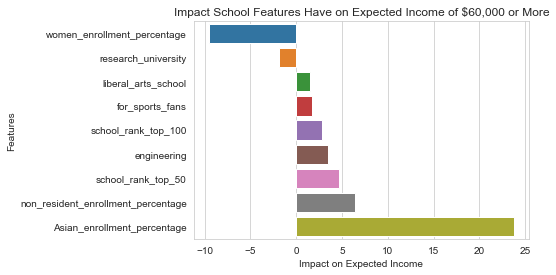

In [252]:
ax = sns.barplot(x='coef', y='features', data=features_df)
plt.xlabel('Impact on Expected Income')
plt.ylabel('Features')
plt.title('Impact School Features Have on Expected Income of $60,000 or More')

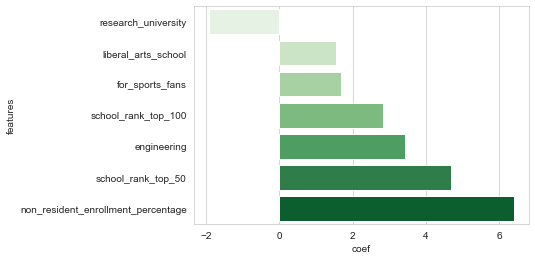

In [250]:
# Visual for presentation 
coef = [3.4183, 1.6713, 1.5505, -1.9078, 6.3865, 4.6797, 2.8388]
features = ['engineering', 'for_sports_fans', 'liberal_arts_school', 'research_university', 'non_resident_enrollment_percentage', 'school_rank_top_50', 'school_rank_top_100']
present_features_df = pd.DataFrame({'coef': coef, 'features':features})
present_features_df.sort_values(by='coef', inplace=True)


sns.barplot(x='coef', y='features', palette='Greens', data=present_features_df)
plt.xlabel('Impact on Expected Income')
plt.ylabel('Features')
plt.title('Impact School Features Have on Expected Income of $60,000 or More');


Results: non-resident enrollment, school rank, engineering, for sports fans, and liberal arts schools have a positive impact on expected salary. Research universities seem to have a negative impact on salary. 